In [1]:
import torch
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import gpytorch
import numpy as np
import torch
import winsound
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from LDGD.model import LDGD, FastLDGD, VAE
from LDGD.visualization.vizualize_utils import plot_heatmap, plot_2d_scatter, plot_ARD_gplvm
from LDGD.visualization.vizualize_utils import plot_loss_gplvm, plot_scatter_gplvm
from LDGD.data.data_loader import generate_data

from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood

from LDGD.utils import dicts_to_dict_of_lists
import json
%matplotlib inline
%load_ext autoreload
%autoreload 2
duration = 1000  # milliseconds
freq = 440  # Hz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [23]:
def create_dataset(random_state, test_size, dataset='synthetic', **kwargs):
    if dataset == 'synthetic':
        # Extract parameters for synthetic data generation
        num_dimension = kwargs.get('num_dimension', 10)
        pattern = kwargs.get('pattern', 'moon')  # default pattern
        n_samples = kwargs.get('n_samples', 1500)
        noise = kwargs.get('noise', 0.1)
        increase_method = kwargs.get('increase_method', 'linear')

        X, y, orig_data = generate_data(pattern, n_samples, noise, num_dimension, increase_method, random_state=random_state)
    elif dataset == 'mnist':
        mnist_train = MNIST(root='./data', train=True, download=True, transform=ToTensor())
        mnist_test = MNIST(root='./data', train=False, download=True, transform=ToTensor())

        # Flatten the images and convert labels
        X = mnist_train.data.view(mnist_train.data.size(0), -1).numpy()
        X = X/X.max()
        y = mnist_train.targets.numpy()

        # Concatenate train and test sets to split them later
        X_test = mnist_test.data.view(mnist_test.data.size(0), -1).numpy()
        y_test = mnist_test.targets.numpy()

        X = np.concatenate((X, X_test), axis=0)
        y = np.concatenate((y, y_test), axis=0)

        orig_data = None  # No original data in the case of MNIST

    # One-hot encode the labels
    y_one_hot = np.zeros((y.shape[0], len(np.unique(y))))
    y_one_hot[np.arange(y.shape[0]), y] = 1

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(X, y_one_hot, y,
                                                                                       test_size=test_size,
                                                                                       random_state=random_state)
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    y_train_labels_tensor = torch.tensor(y_train_labels)
    y_test_labels_tensor = torch.tensor(y_test_labels)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, y_train_labels_tensor, y_test_labels_tensor, orig_data


In [4]:
def create_LDGD_model(data_cont, data_cat, ldgd_settings, batch_shape, x_init='pca'):
    kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))
    kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))

    likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
    likelihood_cls = BernoulliLikelihood()
    model = LDGD(data_cont,
             kernel_reg=kernel_reg,
             kernel_cls=kernel_cls,
             num_classes=data_cat.shape[-1],
             latent_dim=ldgd_settings['latent_dim'],
             num_inducing_points_cls= ldgd_settings['num_inducing_points_cls'],
             num_inducing_points_reg= ldgd_settings['num_inducing_points_reg'],
             likelihood_reg=likelihood_reg,
             likelihood_cls=likelihood_cls,
             use_gpytorch=ldgd_settings['use_gpytorch'],
             shared_inducing_points=ldgd_settings['shared_inducing_points'],
             use_shared_kernel=False,
             x_init=x_init,
             device=device)

    return model

def create_FastLDGD_model(data_cont, data_cat, batch_shape, ldgd_settings):
    kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))
    kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))

    likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
    likelihood_cls = BernoulliLikelihood()
    model = FastLDGD(data_cont,
             kernel_reg=kernel_reg,
             kernel_cls=kernel_cls,
             num_classes=data_cat.shape[-1],
             latent_dim=ldgd_settings['latent_dim'],
             num_inducing_points_cls= ldgd_settings['num_inducing_points_cls'],
             num_inducing_points_reg= ldgd_settings['num_inducing_points_reg'],
             likelihood_reg=likelihood_reg,
             likelihood_cls=likelihood_cls,
             use_gpytorch=ldgd_settings['use_gpytorch'],
             shared_inducing_points=ldgd_settings['shared_inducing_points'],
             use_shared_kernel=False,
             device=device)

    return model

In [36]:
model_settings = {
    'latent_dim': 2,
    'num_inducing_points': 5,
    'num_inducing_points_reg': 20,
    'num_inducing_points_cls': 20,
    'num_epochs_train': 20000,
    'num_epochs_test': 20000,
    'batch_size': 500,
    'load_trained_model': False,
    'load_tested_model': False,
    'dataset': 'synthetic',
    'shared_inducing_points': True,
    'use_gpytorch': True,
    'random_state': 65,
    'test_size': 0.8,
    'cls_weight': 1.0,
    'reg_weight': 1.0,
    'num_samples': 500,

}
np.random.seed(model_settings['random_state'])


In [37]:
# load raw data
yn_train, yn_test, ys_train, ys_test, labels_train, labels_test, _ = create_dataset(random_state=model_settings['random_state'], test_size=0.2, dataset='mnist')
yn_train = yn_train/yn_train.max()
yn_test = yn_test/yn_test.max()


In [38]:
load_saved_result = False
batch_shape = torch.Size([yn_train.shape[-1]])
metric_fastldgd_list = []
model = create_LDGD_model(data_cont=yn_train, data_cat=ys_train, ldgd_settings=model_settings, batch_shape=batch_shape)

if load_saved_result is False:
    losses, history_train = model.train_model(yn=yn_train, ys=ys_train,
                                              epochs=model_settings['num_epochs_train'],
                                              batch_size=model_settings['batch_size'], monitor_mse=False)
    model.save_wights(path_save='./saved_models/', file_name=f"model_mnist")
else:
    model.load_weights(path_save='./saved_models/', file_name=f"model_mnist")


winsound.Beep(freq, duration*3)


Epoch 1/20000, Loss: 986.39111328125
Epoch 11/20000, Loss: 842.810791015625
Epoch 21/20000, Loss: 736.9476928710938
Epoch 31/20000, Loss: 676.9572143554688
Epoch 41/20000, Loss: 618.1353759765625
Epoch 51/20000, Loss: 554.5183715820312
Epoch 61/20000, Loss: 503.18756103515625
Epoch 71/20000, Loss: 450.0085144042969
Epoch 81/20000, Loss: 400.921142578125
Epoch 91/20000, Loss: 361.54193115234375
Epoch 101/20000, Loss: 315.9063415527344
Epoch 111/20000, Loss: 282.5818786621094
Epoch 121/20000, Loss: 237.70925903320312
Epoch 131/20000, Loss: 178.97369384765625
Epoch 141/20000, Loss: 114.69319152832031
Epoch 151/20000, Loss: 92.1321029663086
Epoch 161/20000, Loss: 35.44923782348633
Epoch 171/20000, Loss: -17.030500411987305
Epoch 181/20000, Loss: -73.93238067626953
Epoch 191/20000, Loss: -99.10037994384766
Epoch 201/20000, Loss: -139.49098205566406
Epoch 211/20000, Loss: -199.75531005859375
Epoch 221/20000, Loss: -225.44338989257812
Epoch 231/20000, Loss: -263.73291015625
Epoch 241/20000, L

KeyboardInterrupt: 

In [28]:
predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                    epochs=model_settings['num_epochs_test'])
winsound.Beep(freq, duration*3)


Epoch 1/2000, Loss: -1090.5777587890625
Epoch 11/2000, Loss: -1060.0498046875
Epoch 21/2000, Loss: -1069.6468505859375
Epoch 31/2000, Loss: -1142.285888671875
Epoch 41/2000, Loss: -1084.1724853515625
Epoch 51/2000, Loss: -1253.3775634765625
Epoch 61/2000, Loss: -1202.369140625
Epoch 71/2000, Loss: -968.0673828125
Epoch 81/2000, Loss: -976.2916870117188
Epoch 91/2000, Loss: -1039.446533203125
Epoch 101/2000, Loss: -1073.06494140625
Epoch 111/2000, Loss: -1110.7962646484375
Epoch 121/2000, Loss: -1097.805908203125
Epoch 131/2000, Loss: -1088.1229248046875
Epoch 141/2000, Loss: -1025.3414306640625
Epoch 151/2000, Loss: -907.9972534179688
Epoch 161/2000, Loss: -1129.1453857421875
Epoch 171/2000, Loss: -1085.0634765625
Epoch 181/2000, Loss: -1059.9263916015625
Epoch 191/2000, Loss: -1151.82763671875
Epoch 201/2000, Loss: -1112.799560546875
Epoch 211/2000, Loss: -1026.7763671875
Epoch 221/2000, Loss: -1283.9119873046875
Epoch 231/2000, Loss: -1132.3955078125
Epoch 241/2000, Loss: -1192.29602

 C:\Users\nziaei\anaconda3\envs\graph_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 C:\Users\nziaei\anaconda3\envs\graph_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 C:\Users\nziaei\anaconda3\envs\graph_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 C:\Users\nziaei\anaconda3\envs\graph_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:Precision is ill-defined and being set to 0.0 in

In [29]:

alpha_reg = 1 / model.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
alpha_cls = 1 / model.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

x = model.x.q_mu.cpu().detach().numpy()
std = torch.nn.functional.softplus(model.x.q_log_sigma).cpu().detach().numpy()

x_test = model.x_test.q_mu.cpu().detach().numpy()
std_test = torch.nn.functional.softplus(model.x_test.q_log_sigma).cpu().detach().numpy()

inducing_points = (history_test['z_list_reg'][-1], history_test['z_list_cls'][-1])

latent_dim = x.shape[-1]
values, indices = torch.topk(torch.tensor(alpha_cls), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

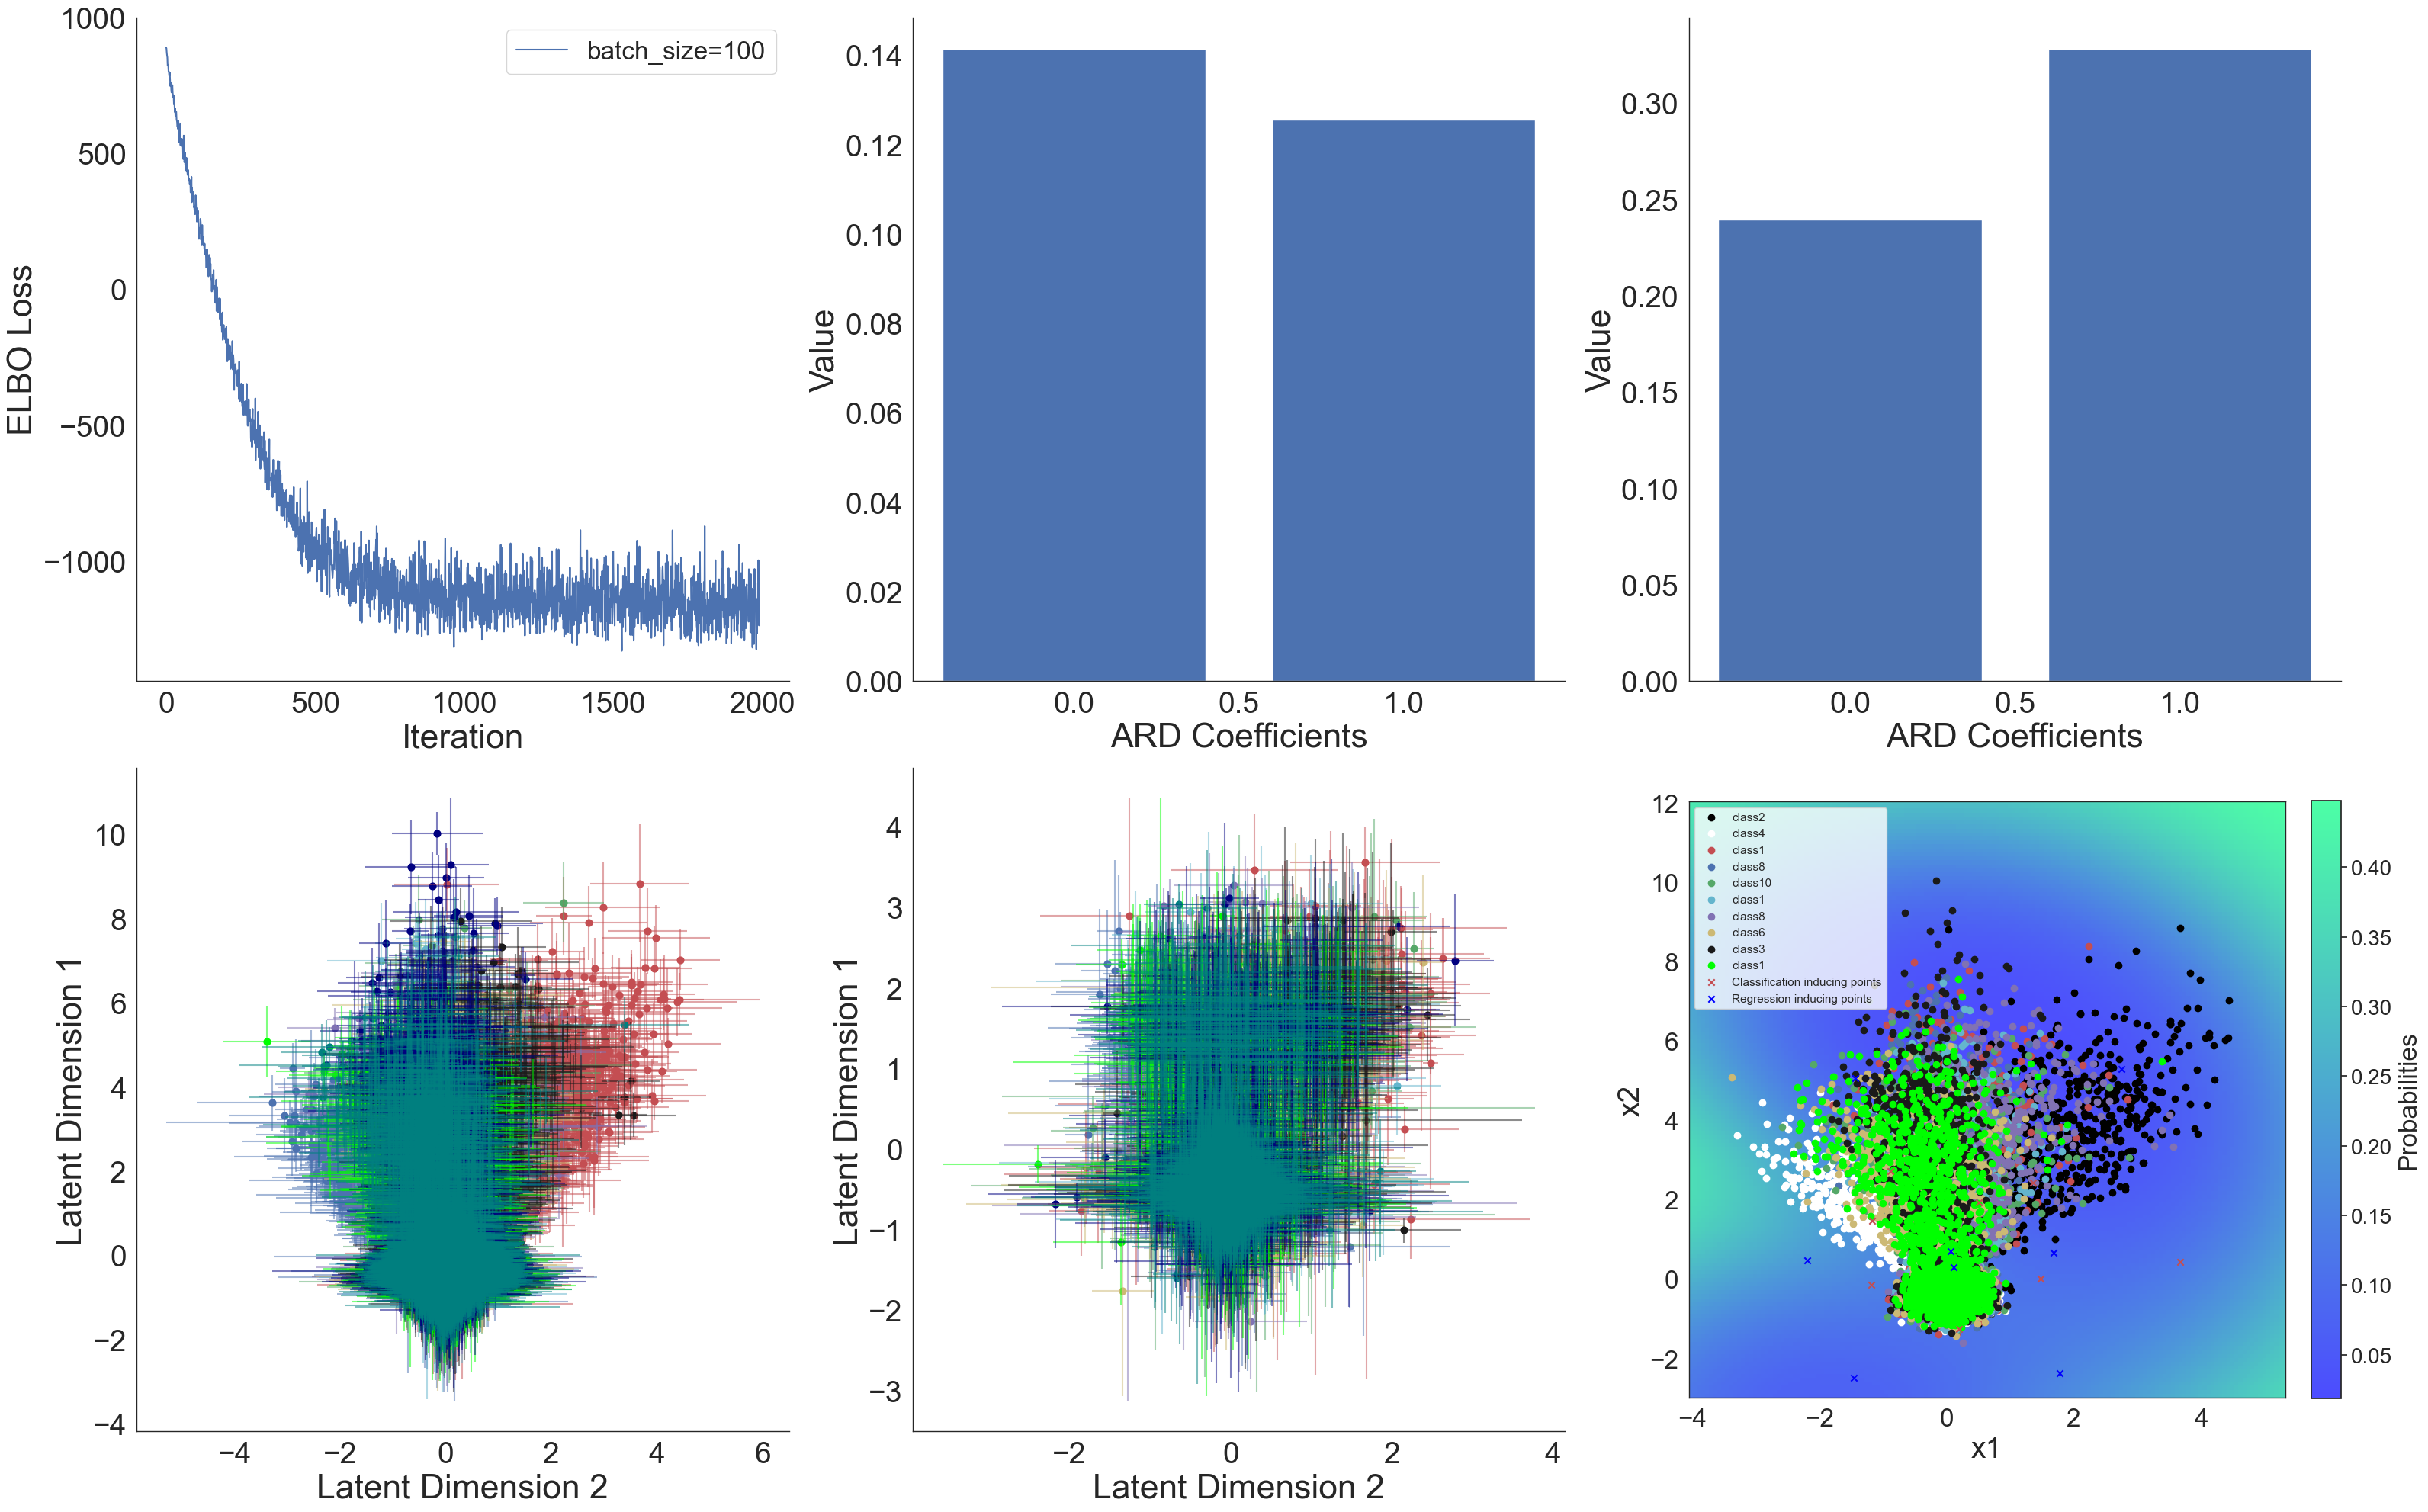

In [35]:
color_list = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'lime', 'navy', 'teal']
fig, axs = plt.subplots(2,3, figsize=(32, 20))


plot_loss_gplvm(losses, ax=axs[0,0])
plot_ARD_gplvm(model_settings['latent_dim'], alpha_cls, ax=axs[0,2])
plot_ARD_gplvm(model_settings['latent_dim'], alpha_reg, ax=axs[0,1])
plot_scatter_gplvm(x, labels_train, l1=l1, l2=l2, ax=axs[1,0], colors=color_list, show_errorbars=True, std=std)
plot_scatter_gplvm(x_test, labels_test, l1=l1, l2=l2, ax=axs[1,1], colors=color_list, show_errorbars=True, std=std_test)

plot_heatmap(x, labels_train, model, alpha_cls, cmap='winter', range_scale=1.2,
             file_name='latent_heatmap_train', inducing_points=inducing_points, ax1=axs[1,2], fig=fig)


plt.tight_layout()
fig.savefig("ARD_synthetic.png")
fig.savefig("ARD_synthetic.svg")

In [ ]:
model.re